In [ ]:
#https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model

In [1]:
import gc
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import seaborn as sns
import matplotlib.pyplot as plt
cmap = plt.get_cmap('jet_r')
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import curve_fit
import folium
import branca
%matplotlib inline

In [5]:
df_table = pd.read_csv('../input/covid_19_master.csv', parse_dates=['Last Update'])
df_table['Date'] = pd.DatetimeIndex(df_table['Last Update']).normalize()

In [8]:
df_table[df_table['Country/Region'] == 'Turkey']

,Unnamed: 0,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,Active,Closed,Date
1164,1164,1.0,Turkey,0.0,2020-03-11 03:33:05,38.9637,35.2433,NaN,0.0,1.0,0.0,2020-03-11
3511,3511,5.0,Turkey,0.0,2020-03-11 20:00:00,38.9637,35.2433,NaN,0.0,5.0,0.0,2020-03-11
4863,4863,5.0,Turkey,0.0,2020-03-13 23:33:06,38.9637,35.2433,NaN,0.0,5.0,0.0,2020-03-13
5471,5471,1.0,Turkey,0.0,2020-03-11 03:33:05,38.9637,35.2433,NaN,0.0,1.0,0.0,2020-03-11


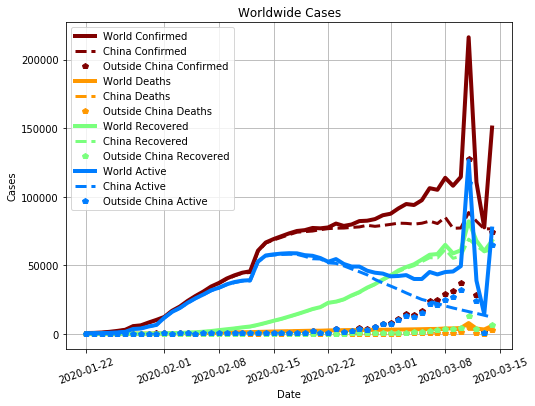

In [11]:
# Worldwide cases
plt.figure(figsize=(8, 6))
cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']
country = 'China'
#continent = 'Asia'
for ic, col in enumerate(cols):
    plt.plot(df_table.groupby('Date').sum()[col], '-', 
             c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=4, label='World '+col)
    plt.plot(df_table[df_table['Country/Region']==country].groupby('Date').sum()[
        col], '--', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label=country+' '+col)
    #plt.plot(df_table[df_table['Continent']==continent].groupby('Date').sum()[
    #    col], ':', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label=continent+' '+col)
    plt.plot(df_table[df_table['Country/Region']!=country].groupby('Date').sum()[
        col], 'p', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label='Outside '+country+' '+col)

plt.title('Worldwide Cases')
plt.xlabel('Date')
plt.xticks(rotation=20)
plt.ylabel('Cases')
plt.grid()
plt.legend()
plt.savefig('../figs/world_cases.png')